In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
%matplotlib inline
from scipy.stats import norm, skew
from scipy import stats

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [103]:
train.shape

(1460, 232)

In [104]:
test.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,LowQualFinSF,GrLivArea,...,GarageQual_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1460,3.044522,4.394449,9.360741,5,1.945910,1961,1961,0.000000,0.0,6.799056,...,1,0,0,1,0,0,0,0,1,0
1461,3.044522,4.406719,9.565775,6,1.945910,1958,1958,4.691348,0.0,7.192934,...,1,0,0,1,0,0,0,0,1,0
1462,4.110874,4.317488,9.534668,5,1.791759,1997,1998,0.000000,0.0,7.396335,...,1,0,0,1,0,0,0,0,1,0
1463,4.110874,4.369448,9.208238,6,1.945910,1998,1998,3.044522,0.0,7.380879,...,1,0,0,1,0,0,0,0,1,0
1464,4.795791,3.784190,8.518392,8,1.791759,1992,1992,0.000000,0.0,7.155396,...,1,0,0,1,0,0,0,0,1,0


In [105]:
test.shape

(1459, 232)

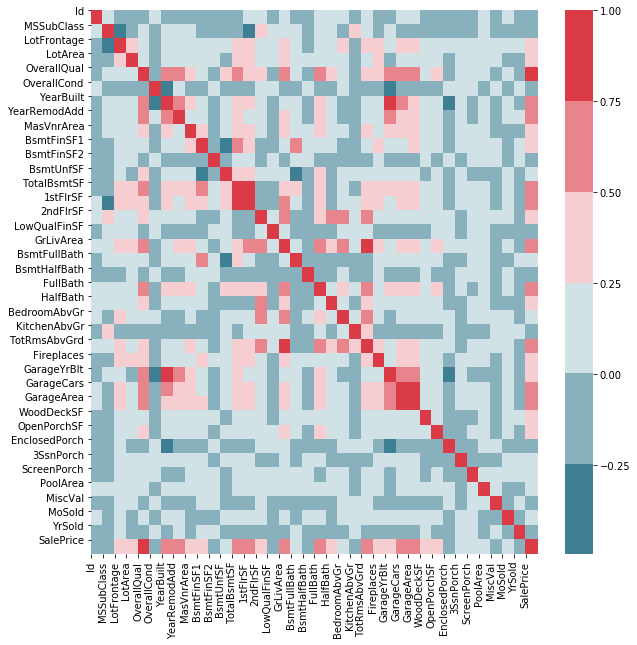

In [7]:
#using heatmap to find correlation between features

corr = train.corr()
fig, ax = plt.subplots(figsize = (10,10))
colormap = sns.diverging_palette(220, 10, as_cmap=False)
sns.heatmap(corr, cmap=colormap, fmt=".2f")
# sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

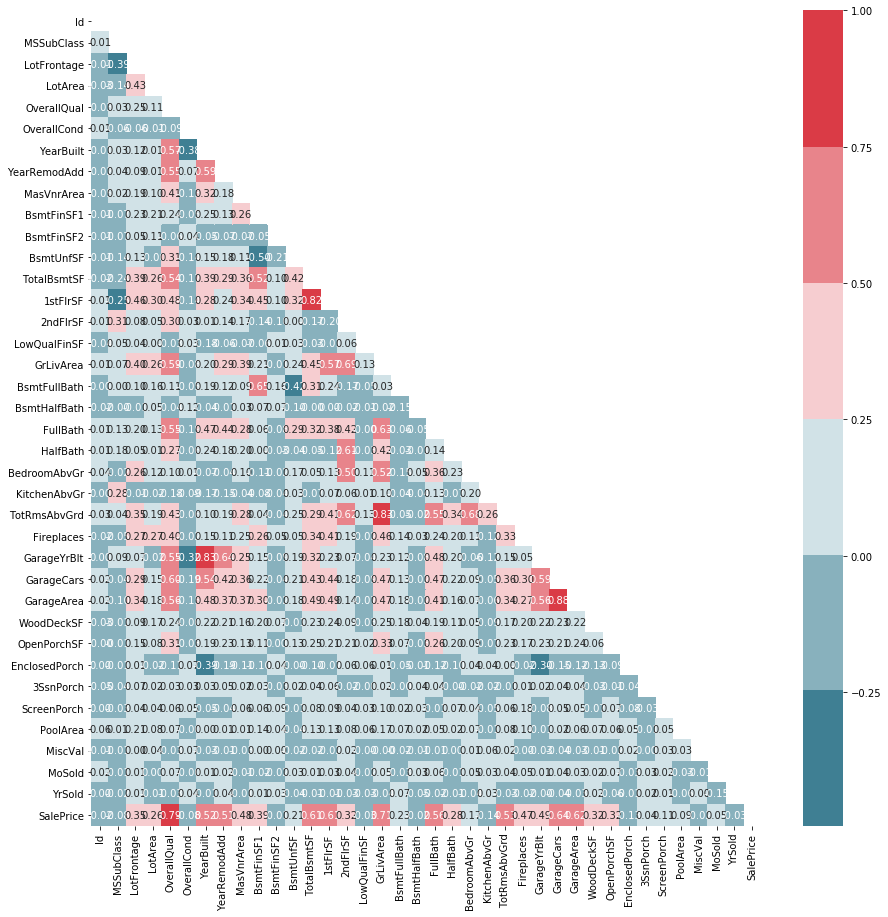

In [8]:
# because X and Y axis are exactly same , we are deleting upper half to better visualization 

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(15,15))
sns.heatmap(corr, cmap=colormap, annot = True,fmt=".2f", mask=mask)

In [9]:
test.shape
# test no sales price 

(1459, 80)

In [10]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [11]:
test.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [12]:
# Get the house_id from the test data set 
test_house_Id = test["Id"]


In [13]:
test_house_Id.head()

0    1461
1    1462
2    1463
3    1464
4    1465
Name: Id, dtype: int64

In [14]:
# Get SalePrice form train dataset 

y_train = train['SalePrice']

In [15]:
y_train

0       208500
1       181500
2       223500
3       140000
4       250000
5       143000
6       307000
7       200000
8       129900
9       118000
10      129500
11      345000
12      144000
13      279500
14      157000
15      132000
16      149000
17       90000
18      159000
19      139000
20      325300
21      139400
22      230000
23      129900
24      154000
25      256300
26      134800
27      306000
28      207500
29       68500
         ...  
1430    192140
1431    143750
1432     64500
1433    186500
1434    160000
1435    174000
1436    120500
1437    394617
1438    149700
1439    197000
1440    191000
1441    149300
1442    310000
1443    121000
1444    179600
1445    129000
1446    157900
1447    240000
1448    112000
1449     92000
1450    136000
1451    287090
1452    145000
1453     84500
1454    185000
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [16]:
train =train.drop(columns =['Id'])

In [17]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [18]:
test =test.drop(columns =['Id'])

In [19]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [20]:
train.shape

(1460, 80)

In [21]:
ntrain = train.shape[0]
ntrain

1460

In [22]:
test.shape

(1459, 79)

In [23]:
ntest = test.shape[0]
ntest

1459

In [24]:
all_data = pd.concat((train,test) , sort = False).reset_index (drop = True)

In [25]:
all_data.shape

(2919, 80)

# Feature Engineering

In [26]:
all_data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [27]:
# combining columns together to create new features for better results


#total sf = first floor _ 2nd floor + basement
all_data['total_SF'] = all_data['1stFlrSF']+all_data['2ndFlrSF']+all_data['TotalBsmtSF']
all_data['total_outdoor_sf']= all_data['3SsnPorch']+all_data['WoodDeckSF']+all_data['OpenPorchSF']+all_data['EnclosedPorch']+all_data['ScreenPorch']

In [28]:
all_data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [29]:
# deleting those columns that merged
all_data = all_data.drop(columns = ['1stFlrSF','2ndFlrSF','TotalBsmtSF','3SsnPorch',
                                    'WoodDeckSF','OpenPorchSF','EnclosedPorch',
                                   'ScreenPorch'
                                   ])

In [30]:
all_data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolArea', 'PoolQC', 'Fence', 'MiscFeatur

In [31]:
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,total_SF,total_outdoor_sf
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,0,2,2008,WD,Normal,208500.0,2566.0,61
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,0,5,2007,WD,Normal,181500.0,2524.0,298
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,0,9,2008,WD,Normal,223500.0,2706.0,42
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,2473.0,307
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,0,12,2008,WD,Normal,250000.0,3343.0,276


In [32]:
# Dealing with Missing data 

all_data_na = (all_data.isnull().sum() / len(all_data))
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:50]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,0.996574
MiscFeature,0.964029
Alley,0.932169
Fence,0.804385
SalePrice,0.499829
FireplaceQu,0.486468
LotFrontage,0.166495
GarageFinish,0.054471
GarageCond,0.054471
GarageQual,0.054471


In [33]:
# dealing with the missing value one by one

# PoolQC: pool quality 99% 
# MisceFeature : 96%
# Alley: 93%
# Fence: 80%
# FireplaceQu 49% - Fireplace quality 
# As per the coorelationshop heatmap, we can drop these columns directly 
# GarageCond,GarageFinish,GarageYrBlt,GarageType


all_data = all_data.drop(columns =['PoolQC','MiscFeature','Alley','Fence','FireplaceQu',
                                   'GarageCond','GarageFinish',
                                  'GarageYrBlt','GarageType',
                                   'Utilities','Functional','SaleType','GarageCars',
                                   'GarageArea','BsmtUnfSF','BsmtFinSF2','BsmtFinSF1'
                                  ])

In [34]:
# filling empty cells

all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.mean()))

In [35]:
 all_data['GarageQual'] = all_data['GarageQual'].fillna('None')

In [36]:
for col in ('BsmtFullBath', 'BsmtHalfBath','total_SF'):
    all_data[col] = all_data[col].fillna(0)
    

In [37]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [38]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])


In [39]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

In [40]:
all_data = all_data.drop(columns =["SalePrice"])

In [41]:
all_data.shape

(2919, 56)

In [42]:
# Dealing with Missing data 
all_data_na = (all_data.isnull().sum() / len(all_data))
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:50]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(50)
# ignore those features 

,Missing Ratio


In [43]:
# All Numerical data -- SOME SHOULD BE CATERGORIAL COLUMNS 

all_num = all_data.select_dtypes(exclude=['object']).columns
all_num

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'total_SF', 'total_outdoor_sf'],
      dtype='object')

In [44]:
# Data Skewness is asymmetry in a statistical distribution, in which the curve appears 
# distorted or skewed either to the left or to the right. 
# Skewness can be quantified to define the extent to which a distribution differs from a normal distribution.


skewed_feature = all_data[all_num].apply(lambda x : skew(x.dropna()))
skewed_feature

MSSubClass           1.375457
LotFrontage          1.460429
LotArea             12.822431
OverallQual          0.197110
OverallCond          0.570312
YearBuilt           -0.599806
YearRemodAdd        -0.451020
MasVnrArea           2.613592
LowQualFinSF        12.088761
GrLivArea            1.269358
BsmtFullBath         0.624832
BsmtHalfBath         3.931594
FullBath             0.167606
HalfBath             0.694566
BedroomAbvGr         0.326324
KitchenAbvGr         4.302254
TotRmsAbvGrd         0.758367
Fireplaces           0.733495
PoolArea            16.898328
MiscVal             21.947195
MoSold               0.195884
YrSold               0.132399
total_SF             1.500247
total_outdoor_sf     1.376649
dtype: float64

In [45]:
skewed_feature = skewed_feature[skewed_feature >0.5 ]

In [46]:
skewed_feature = skewed_feature.index

In [47]:
all_data[skewed_feature] = np.log1p(all_data[skewed_feature])

In [48]:
all_data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,LowQualFinSF,GrLivArea,...,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,PoolArea,MiscVal,MoSold,YrSold,total_SF,total_outdoor_sf
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,3.820503,4.212917,9.094915,6.089072,1.867152,1971.312778,1984.264474,2.079239,0.077100,7.261502,...,2.860226,0.710829,1.986955,0.389300,0.027361,0.234767,6.213087,2007.792737,7.793142,4.287988
std,0.692436,0.328868,0.509882,1.409947,0.173171,30.291442,20.894344,2.620916,0.659472,0.324750,...,0.822693,0.088196,0.206864,0.394826,0.410265,1.240206,2.714762,1.314964,0.344440,2.038110
min,3.044522,3.091042,7.170888,1.000000,0.693147,1872.000000,1950.000000,0.000000,0.000000,5.814131,...,0.000000,0.000000,1.098612,0.000000,0.000000,0.000000,1.000000,2006.000000,0.000000,0.000000
25%,3.044522,4.110874,8.919854,5.000000,1.791759,1953.500000,1965.000000,0.000000,0.000000,7.027315,...,2.000000,0.693147,1.791759,0.000000,0.000000,0.000000,4.000000,2007.000000,7.601402,3.891820
50%,3.931826,4.262680,9.154193,6.000000,1.791759,1973.000000,1993.000000,0.000000,0.000000,7.275865,...,3.000000,0.693147,1.945910,0.693147,0.000000,0.000000,6.000000,2008.000000,7.803435,5.105945
75%,4.262680,4.394449,9.356257,7.000000,1.945910,2001.000000,2004.000000,5.102906,0.000000,7.464223,...,3.000000,0.693147,2.079442,0.693147,0.000000,0.000000,8.000000,2009.000000,8.003864,5.589118
max,5.252273,5.749393,12.279537,10.000000,2.302585,2010.000000,2010.000000,7.378384,6.970730,8.638171,...,8.000000,1.386294,2.772589,1.609438,6.685861,9.741027,12.000000,2010.000000,9.371864,7.261927


In [49]:
# log transform the target price 

y_train = train['SalePrice']

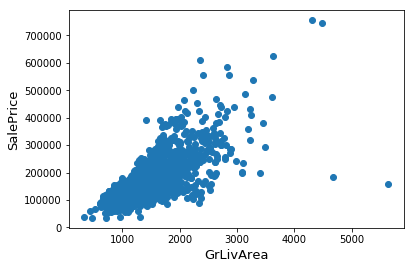

In [50]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

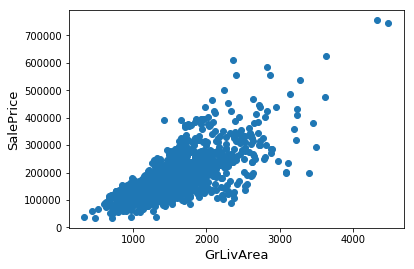

In [51]:
# these two values are outliers.. not follow the regression 
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice'] < 300000)].index)
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [52]:
y_train = np.log1p(y_train)
y_train.head()

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64

In [53]:
all_data.shape


# now we are dealing with 74 features

(2919, 56)

In [54]:
# categorical data 

# get_dummies -- convert the catergocial data to indicatior variables 

all_data = pd.get_dummies(all_data)

In [55]:
all_data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,LowQualFinSF,GrLivArea,...,GarageQual_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,3.820503,4.212917,9.094915,6.089072,1.867152,1971.312778,1984.264474,2.079239,0.077100,7.261502,...,0.892086,0.073998,0.021240,0.904762,0.065091,0.004111,0.008222,0.015759,0.822885,0.083933
std,0.692436,0.328868,0.509882,1.409947,0.173171,30.291442,20.894344,2.620916,0.659472,0.324750,...,0.310325,0.261812,0.144209,0.293594,0.246728,0.063996,0.090317,0.124562,0.381832,0.277335
min,3.044522,3.091042,7.170888,1.000000,0.693147,1872.000000,1950.000000,0.000000,0.000000,5.814131,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.044522,4.110874,8.919854,5.000000,1.791759,1953.500000,1965.000000,0.000000,0.000000,7.027315,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,3.931826,4.262680,9.154193,6.000000,1.791759,1973.000000,1993.000000,0.000000,0.000000,7.275865,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,4.262680,4.394449,9.356257,7.000000,1.945910,2001.000000,2004.000000,5.102906,0.000000,7.464223,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,5.252273,5.749393,12.279537,10.000000,2.302585,2010.000000,2010.000000,7.378384,6.970730,8.638171,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [56]:
all_data.shape

(2919, 232)

In [57]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [58]:
train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,LowQualFinSF,GrLivArea,...,GarageQual_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,1.791759,2003,2003,5.283204,0.0,7.444833,...,1,0,0,1,0,0,0,0,1,0
1,3.044522,4.394449,9.169623,6,2.197225,1976,1976,0.000000,0.0,7.141245,...,1,0,0,1,0,0,0,0,1,0
2,4.110874,4.234107,9.328212,7,1.791759,2001,2002,5.093750,0.0,7.488294,...,1,0,0,1,0,0,0,0,1,0
3,4.262680,4.110874,9.164401,7,1.791759,1915,1970,0.000000,0.0,7.448916,...,1,0,0,1,1,0,0,0,0,0
4,4.110874,4.442651,9.565284,8,1.791759,2000,2000,5.860786,0.0,7.695758,...,1,0,0,1,0,0,0,0,1,0


# Modeling : Ridge , Kfolds , Lasso , XGBoost , Stack Gen

In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV

In [60]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, train, y_train, scoring="neg_mean_squared_error", cv = 1460))
    return(rmse)

In [61]:
#alphas for different model

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [62]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold


ridge = Ridge
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))


In [63]:
from sklearn.linear_model import ElasticNetCV
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))  

In [64]:
from sklearn.svm import SVR
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [65]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)

In [66]:
from xgboost import XGBRegressor
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [67]:
from mlxtend.regressor import StackingCVRegressor
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

# Fit Models

In [68]:
print('START Fit')

print('stack_gen')
stack_gen_model = stack_gen.fit(train,y_train)

START Fit
stack_gen


In [69]:
print('elasticnet')
elastic_model_full_data = elasticnet.fit(train, y_train)

elasticnet


In [70]:
print('Lasso')
lasso_model_full_data = lasso.fit(train, y_train)

Lasso


In [75]:
print('Ridge')
ridge_model_full_data = ridge.fit(train, y_train)

Ridge


In [72]:
print('Svr')
svr_model_full_data = svr.fit(train,y_train)

Svr


In [73]:
print('GradientBoosting')
gbr_model_full_data = gbr.fit(train, y_train)

GradientBoosting


In [129]:
print('xgboost')
xgb_model_full_data = xgboost.fit(train, y_train)

xgboost


/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


# Prediction

In [99]:
# Stack_gen_Model Prediction
stack_gen_model_pred = stack_gen_model.predict(np.array(test))
stack_gen_model_pred

array([11.689221, 12.072298, 12.115295, ..., 11.938049, 11.689757,
       12.240259], dtype=float32)

In [131]:
#turning our Logarithmic prices to regular prices

Actual_Pred_1 = [np.expm1(x) for x in stack_gen_model_pred]
Actual_Pred_1

[119278.09,
 174956.44,
 182643.22,
 201771.14,
 180836.02,
 173957.69,
 171944.78,
 167211.94,
 190110.67,
 121171.95,
 181225.16,
 93543.07,
 94305.08,
 147590.08,
 118458.266,
 400124.78,
 251463.88,
 278308.1,
 270873.75,
 527756.7,
 359288.4,
 212988.9,
 171125.69,
 164480.34,
 183299.5,
 191289.89,
 333954.94,
 222603.16,
 202262.8,
 233255.23,
 187820.73,
 94746.164,
 167317.69,
 268699.66,
 262493.25,
 239563.64,
 168717.98,
 162454.19,
 163667.92,
 160906.28,
 186196.89,
 141746.97,
 306882.34,
 250618.03,
 224364.47,
 188497.05,
 255701.95,
 204362.67,
 160215.08,
 144805.95,
 138633.7,
 164438.0,
 142841.28,
 149398.92,
 194478.77,
 147177.81,
 169700.89,
 119402.61,
 210745.94,
 134737.28,
 135639.77,
 158991.77,
 119272.75,
 129188.836,
 125330.086,
 118469.67,
 98714.3,
 141239.06,
 151557.23,
 183904.47,
 110273.01,
 93630.18,
 137553.53,
 121369.72,
 148777.86,
 115234.67,
 60556.277,
 157385.27,
 184288.97,
 83326.266,
 143750.05,
 143328.84,
 210490.23,
 85742.42,
 12

In [101]:
#elastic_model predictions:
elastic_model_pred = elastic_model_full_data.predict(test)
elastic_model_pred

array([11.64930495, 11.97893609, 12.09311562, ..., 12.00213484,
       11.70755702, 12.27574338])

In [102]:
Actual_Pred_2 = [np.expm1(x) for x in elastic_model_pred]
Actual_Pred_2

[114610.67464826885,
 159361.39248765592,
 178636.80804188256,
 196101.49065566793,
 195647.06723271986,
 169740.07696765766,
 173882.56442408098,
 161455.11482022464,
 201971.1812259217,
 111731.43759806149,
 184357.16343632492,
 96837.0799103046,
 93526.0957423197,
 141408.26958426344,
 110231.89168011685,
 352217.1865048409,
 240631.01297011736,
 298961.48993103585,
 309842.6295450417,
 470962.36133823695,
 325169.87631015986,
 223755.29059841696,
 181314.60584160467,
 163358.75740644164,
 192278.8250981886,
 194931.2947189369,
 322788.9060725179,
 233048.7164317643,
 192595.6070316074,
 234380.03415374624,
 197697.6121975355,
 93446.04591071613,
 187489.69992888984,
 282847.12757141475,
 282060.0456501237,
 236031.33181694936,
 179038.75520922404,
 165460.6343064354,
 163473.21575134227,
 156742.52911143083,
 176524.3742392049,
 145103.71803631776,
 276706.3449292871,
 244586.16391176346,
 224900.07149685148,
 193217.72534589705,
 244909.95603391223,
 204884.63962554297,
 162809.81

In [ ]:
# Lasso Model predictions : 
lasso_model_pred = lasso_model_full_data.predict(test)
lasso_model_pred

In [85]:
Actual_Pred_3 = [np.expm1(x) for x in lasso_model_pred]
Actual_Pred_3

[114583.96609206217,
 159350.54933747282,
 178643.08500944037,
 196114.4925423809,
 195624.92780673818,
 169759.82948760712,
 173908.26548291478,
 161466.5265749764,
 202010.71572003292,
 111743.19723521853,
 184500.53901368642,
 96841.69873799753,
 93521.36033434076,
 141442.2679335667,
 110271.26641629459,
 352140.31890469993,
 240582.42954836498,
 298896.3654641247,
 309829.9241103025,
 470808.1688992971,
 325149.7410753163,
 223745.4992592463,
 181327.96729009622,
 163347.51507724755,
 192292.21844877172,
 194983.94271565703,
 322698.4192648648,
 233102.62122144704,
 192568.02329012152,
 234324.74945738877,
 197694.68724149672,
 93411.67911848995,
 187529.16152768768,
 282847.4840888834,
 282062.5861090646,
 235993.80564479416,
 179055.260664129,
 165455.90166810696,
 163477.61019506518,
 156741.821878881,
 176467.57594666403,
 145127.04916665942,
 276727.4532070134,
 244598.2328152904,
 224876.30295450037,
 193229.57206102865,
 244955.78304247858,
 204900.9055864068,
 162820.76592

In [106]:
# Ridge Model prediction : 

ridge_model_pred = ridge_model_full_data.predict(test)
ridge_model_pred

array([11.6350057 , 11.98579781, 12.08722109, ..., 12.01587183,
       11.71205812, 12.26221187])

In [107]:
Actual_Pred_4 = [np.expm1(x) for x in ridge_model_pred]
Actual_Pred_4

[112983.4754771966,
 160458.65296583352,
 177586.9208230566,
 194823.89188075537,
 192610.64140622757,
 167795.77113476043,
 170233.22587034674,
 160693.99030467522,
 198482.05097041422,
 110562.7819565261,
 178506.44231524237,
 95960.80396446658,
 93315.01621506219,
 141170.22235980965,
 108440.2602812212,
 345163.6617936192,
 240342.73029201466,
 300633.4414199085,
 309767.11968317576,
 478563.0329761383,
 323164.70058019354,
 225546.66978933307,
 180715.70305476454,
 166998.50979088296,
 194724.36579784058,
 192934.38946545872,
 323405.6963614264,
 230395.21419091194,
 190672.21544026476,
 236075.21580806526,
 198874.7588060422,
 92163.68374282616,
 185265.39057603848,
 282643.92095582094,
 277554.1204094452,
 237638.9787320587,
 177464.21907595714,
 166571.82858309775,
 162550.58393320534,
 154963.13056308884,
 179042.02666374706,
 144907.68718003988,
 271540.00648769294,
 245346.25257761983,
 226757.22294332148,
 192920.86146403846,
 242765.0714664996,
 204278.9326702316,
 161692.

In [109]:
# svr_model prediction
svr_model_pred = svr_model_full_data.predict(test)
svr_model_pred

array([11.68013515, 12.02049547, 12.14157596, ..., 12.02784735,
       11.78760473, 12.24349836])

In [110]:
Actual_Pred_5 = [np.expm1(x) for x in svr_model_pred]
Actual_Pred_5

[118199.20863200806,
 166123.94547725606,
 187506.84494268158,
 201053.23164985943,
 192114.4262792451,
 171220.74217463506,
 175330.50162778603,
 163478.6367831226,
 203225.71319469987,
 113704.8024336719,
 173067.3149276259,
 99322.15411452555,
 96460.13288297875,
 145164.40600374696,
 111222.938734506,
 368562.70265327464,
 239210.80754314444,
 311226.516294931,
 315384.97737801174,
 495730.95031362504,
 330435.1750929428,
 220829.64594089243,
 182326.88715108228,
 164214.85425733947,
 185051.89479487314,
 193426.573576205,
 324179.1842558848,
 236079.0099706016,
 199978.65289826452,
 240275.63613216224,
 203976.41739103323,
 97404.14262787494,
 193029.96662531982,
 279814.2705979896,
 283667.18634289736,
 235410.91146938203,
 183684.55606453842,
 169418.7264527371,
 165406.78445100816,
 161112.7539459104,
 184129.18230778456,
 140740.8376258835,
 286185.61601632077,
 245843.4417991084,
 227304.54423659274,
 194518.6431345181,
 248434.28887027665,
 210243.6438783363,
 166375.8667187

In [93]:
# gbr model prediction : 

gbr_model_predict = gbr_model_full_data.predict(test)
gbr_model_predict

In [95]:
Actual_Pred_6 = [np.expm1(x) for x in gbr_model_predict]
Actual_Pred_6

[128361.27275290413,
 174516.58535779055,
 183744.50585438585,
 200667.452753925,
 180365.29068369337,
 171650.8548201856,
 169178.50773864266,
 165224.25033156248,
 184487.99943997397,
 120475.45337862406,
 185324.18083398853,
 94239.70766831623,
 97212.07191451639,
 147864.42262146348,
 117496.90019184999,
 388581.2343031508,
 261530.4565599362,
 284207.2076347045,
 285908.6679673844,
 481324.0269818086,
 354921.3434649291,
 208295.69153984886,
 175727.60897744945,
 160945.2383329532,
 187720.11119907105,
 193896.36021223752,
 331745.9239726834,
 224035.64535503657,
 199161.57849958376,
 231195.28388088293,
 195353.59923648534,
 95438.59942093739,
 186054.27334008756,
 271055.2106595358,
 252893.91350100626,
 241417.29317502008,
 168389.43313008442,
 164352.92180439187,
 164199.6494445081,
 163792.63809874223,
 188709.579174683,
 141362.78004660562,
 273891.50795426324,
 254077.36646240196,
 225084.18707474123,
 186784.03117839317,
 241662.17347452184,
 202305.07812449563,
 161756.23

In [111]:
# xgb model prediction

xgb_model_pred = xgb_model_full_data .predict(test)
xgb_model_pred

array([11.714479, 12.033028, 12.109154, ..., 11.984248, 11.702483,
       12.258401], dtype=float32)

In [98]:
Actual_Pred_7 = [np.expm1(x) for x in xgb_model_pred]
Actual_Pred_7

[122329.23,
 168218.95,
 181524.92,
 195836.31,
 185228.81,
 173028.48,
 174939.1,
 165331.78,
 194627.2,
 120611.17,
 184001.3,
 97280.58,
 96866.85,
 151542.78,
 115403.16,
 398202.0,
 251149.67,
 286692.72,
 285814.78,
 508161.94,
 363944.0,
 212772.69,
 171253.86,
 168602.97,
 181890.56,
 193976.61,
 328821.3,
 230675.39,
 202756.25,
 223807.55,
 188865.58,
 92189.12,
 175906.06,
 282410.03,
 283270.22,
 230135.72,
 176121.44,
 158575.19,
 156402.36,
 152307.22,
 179669.14,
 143117.67,
 302894.28,
 246794.44,
 227104.72,
 193443.83,
 258034.8,
 197701.39,
 159153.48,
 139578.12,
 137545.66,
 166634.23,
 139535.0,
 142679.53,
 188783.1,
 148206.6,
 171131.73,
 133154.7,
 216601.48,
 133050.11,
 135677.4,
 158755.86,
 116909.13,
 127464.49,
 126055.55,
 117748.56,
 99236.28,
 139586.78,
 149439.81,
 178972.27,
 105870.625,
 96754.12,
 137084.56,
 116964.23,
 149627.2,
 115289.85,
 60879.273,
 161541.3,
 184393.73,
 83847.61,
 141299.95,
 143181.84,
 222115.42,
 77525.805,
 111582.99,

# Combining Predictions

In [ ]:
# combined_predic = .1*elastic_model_pred+0.1*lasso_model_pred+0.1*ridge_model_pred 
# +0.1*svr_model_pred +0.15*gbr_model_predict+0.05*xgb_model_pred+0.4*stack_gen_model_pred

In [115]:
combined_predic = .1*elastic_model_pred+0.05*lasso_model_pred+0.1*ridge_model_pred+0.1*svr_model_pred+0.1*gbr_model_predict+0.15*xgb_model_pred+0.4*stack_gen_model_pred

In [116]:
#combined_predic = 0.4*lasso_model_pred+0.1*ridge_model_pred+0.1*xgb_model_pred+0.4*stack_gen_model_pred

In [117]:
Actual_Pred_8 = [np.expm1(x) for x in combined_predic]
Actual_Pred_8

[119134.89400232903,
 169111.25415270386,
 181946.06295520146,
 199133.4614201364,
 185878.08296006263,
 172053.53378013553,
 172565.89524866256,
 164825.07164950573,
 194065.20309541482,
 117713.49293825317,
 181408.05226714487,
 95467.0279335851,
 94968.83083523999,
 146361.35354519085,
 114882.48119369423,
 382219.19294821186,
 248365.84648549726,
 288559.4430753804,
 288270.43199660466,
 503010.3436564734,
 347545.7738826345,
 216069.068730236,
 175148.92069559466,
 164788.04519824698,
 186144.289115709,
 192875.4286168867,
 329218.89256080537,
 227598.58345556757,
 199138.01109328918,
 232739.85744365898,
 192849.41650225688,
 94229.97249489237,
 177609.41488785058,
 275542.36231162003,
 270980.712731998,
 237169.69649569775,
 173632.21540631956,
 163593.2145889773,
 162641.3403989238,
 158664.7848732816,
 183046.25592187035,
 142626.256461865,
 292477.9457219922,
 248462.91817984413,
 225456.7694972895,
 190801.4257139576,
 250934.8744736876,
 203791.2970220903,
 161350.954178169

In [118]:
test["SalePrice"] = Actual_Pred_8

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [119]:
test.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'LowQualFinSF', 'GrLivArea',
       ...
       'PavedDrive_N', 'PavedDrive_P', 'PavedDrive_Y', 'SaleCondition_Abnorml',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family',
       'SaleCondition_Normal', 'SaleCondition_Partial', 'SalePrice'],
      dtype='object', length=233)

In [120]:
test['Id'] = list(test_house_Id)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [121]:
list(test_house_Id)

[1461,
 1462,
 1463,
 1464,
 1465,
 1466,
 1467,
 1468,
 1469,
 1470,
 1471,
 1472,
 1473,
 1474,
 1475,
 1476,
 1477,
 1478,
 1479,
 1480,
 1481,
 1482,
 1483,
 1484,
 1485,
 1486,
 1487,
 1488,
 1489,
 1490,
 1491,
 1492,
 1493,
 1494,
 1495,
 1496,
 1497,
 1498,
 1499,
 1500,
 1501,
 1502,
 1503,
 1504,
 1505,
 1506,
 1507,
 1508,
 1509,
 1510,
 1511,
 1512,
 1513,
 1514,
 1515,
 1516,
 1517,
 1518,
 1519,
 1520,
 1521,
 1522,
 1523,
 1524,
 1525,
 1526,
 1527,
 1528,
 1529,
 1530,
 1531,
 1532,
 1533,
 1534,
 1535,
 1536,
 1537,
 1538,
 1539,
 1540,
 1541,
 1542,
 1543,
 1544,
 1545,
 1546,
 1547,
 1548,
 1549,
 1550,
 1551,
 1552,
 1553,
 1554,
 1555,
 1556,
 1557,
 1558,
 1559,
 1560,
 1561,
 1562,
 1563,
 1564,
 1565,
 1566,
 1567,
 1568,
 1569,
 1570,
 1571,
 1572,
 1573,
 1574,
 1575,
 1576,
 1577,
 1578,
 1579,
 1580,
 1581,
 1582,
 1583,
 1584,
 1585,
 1586,
 1587,
 1588,
 1589,
 1590,
 1591,
 1592,
 1593,
 1594,
 1595,
 1596,
 1597,
 1598,
 1599,
 1600,
 1601,
 1602,
 1603,

In [122]:
for i in test.columns:
    print(i)

MSSubClass
LotFrontage
LotArea
OverallQual
OverallCond
YearBuilt
YearRemodAdd
MasVnrArea
LowQualFinSF
GrLivArea
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
TotRmsAbvGrd
Fireplaces
PoolArea
MiscVal
MoSold
YrSold
total_SF
total_outdoor_sf
MSZoning_C (all)
MSZoning_FV
MSZoning_RH
MSZoning_RL
MSZoning_RM
Street_Grvl
Street_Pave
LotShape_IR1
LotShape_IR2
LotShape_IR3
LotShape_Reg
LandContour_Bnk
LandContour_HLS
LandContour_Low
LandContour_Lvl
LotConfig_Corner
LotConfig_CulDSac
LotConfig_FR2
LotConfig_FR3
LotConfig_Inside
LandSlope_Gtl
LandSlope_Mod
LandSlope_Sev
Neighborhood_Blmngtn
Neighborhood_Blueste
Neighborhood_BrDale
Neighborhood_BrkSide
Neighborhood_ClearCr
Neighborhood_CollgCr
Neighborhood_Crawfor
Neighborhood_Edwards
Neighborhood_Gilbert
Neighborhood_IDOTRR
Neighborhood_MeadowV
Neighborhood_Mitchel
Neighborhood_NAmes
Neighborhood_NPkVill
Neighborhood_NWAmes
Neighborhood_NoRidge
Neighborhood_NridgHt
Neighborhood_OldTown
Neighborhood_SWISU
Neighborhood_Sawye

In [123]:
final_data = test[['Id','SalePrice']]

In [124]:
final_data.reset_index(drop=True)

,Id,SalePrice
0,1461,119134.894002
1,1462,169111.254153
2,1463,181946.062955
3,1464,199133.461420
4,1465,185878.082960
5,1466,172053.533780
6,1467,172565.895249
7,1468,164825.071650
8,1469,194065.203095
9,1470,117713.492938


In [127]:
final_data.head()

,Id,SalePrice
1460,1461,119134.894002
1461,1462,169111.254153
1462,1463,181946.062955
1463,1464,199133.461420
1464,1465,185878.082960


In [128]:
final_data.to_csv("Hourse price Prediction_final.csv" ,index = False)